# Лабораторная работа №4 "Проведение исследований со случайным лесом"

## Подключение вспомогательных библиотек

In [56]:
from typing import Union
from dataclasses import dataclass
import collections
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.ensemble

## Классификация

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [2]:
!kaggle datasets download -q -p dataset -d saurabhbadole/bank-customer-churn-prediction-dataset
!unzip dataset/bank-customer-churn-prediction-dataset.zip -d dataset/

ds = pd.read_csv("dataset/Churn_Modelling.csv")
ds.head()

baseline_ds = ds.drop(columns=["RowNumber", "CustomerId", "Surname"])

baseline_ds = pd.get_dummies(baseline_ds, columns=["Geography"], dtype=int)
baseline_ds = pd.get_dummies(baseline_ds, columns=["Gender"], dtype=int)

baseline_ds.head()

Dataset URL: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Archive:  dataset/bank-customer-churn-prediction-dataset.zip
  inflating: dataset/Churn_Modelling.csv  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [3]:
def generate_train_data(dataset, *, target_feature="Exited", random_state=42, test_size=0.2):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]

  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
  precision = sklearn.metrics.precision_score(y_test, y_pred)
  recall = sklearn.metrics.recall_score(y_test, y_pred)
  f1 = sklearn.metrics.f1_score(y_test, y_pred)

  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

  return {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": confusion_matrix,
  }


def print_model_metrics(model, X_test, y_test):
  metrics = get_model_metrics(model, X_test, y_test)

  print(f"Accuracy: {metrics['accuracy']:.4f}")
  print(f"Precision: {metrics['precision']:.4f}")
  print(f"Recall: {metrics['recall']:.4f}")
  print(f"F1-Score: {metrics['f1']:.4f}")

  print("\nConfusion Matrix:")
  print(metrics["confusion_matrix"])


Обучим теперь модель решающего дерева для решения задачи классификации на бейзлайн-датасете, который мы ранее определили, и выведем на экран показатели метрик для итоговой обученной модели.

In [4]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.ensemble.RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8650
Precision: 0.7510
Recall: 0.4682
F1-Score: 0.5768

Confusion Matrix:
[[1546   61]
 [ 209  184]]


На основе полученных данных можно сделать следующие выводы о качестве обученной модели.

Высокие значения метрики "Accuracy" говорят нам о том, что модель имеет хорошую способность избегать ложных срабатываний. Однако, судя по значениям метрики "Recall" мы можем сделать вывод, что модель теряет значительно колчиество объектов меньшинства.

Итого, при дальнейшем улучшении бейзлайна предлагается сделать упор на то, чтобы помочь модели учитывать несбалансированность данных.

### 3. Улучшение бейзлайна

#### Удаление лишних признаков

Одной из проблем со стороны датасета, которая может ухудшить итоговое качество модели, может быть мльтиуколлинеарность признаков.

Так как мльтиколлинеарные признаки несут дублирующую информацию, то деревья в ансамбле могут излишне сосредотачиваться на этих взаимосвязанных признаках, что приводит к ненужному усложнению модели, или, при использовании таких алгоритмов определения важности признаков, как Gini, может возникнуть ситуация, когда алгоритм будет завышать значимость одного из мультиколлинеарных признаков, "забывая" о других.

Для обнаруженая мальтиколлинеарных пар признаков визуализируем матрицу коллинеарности.


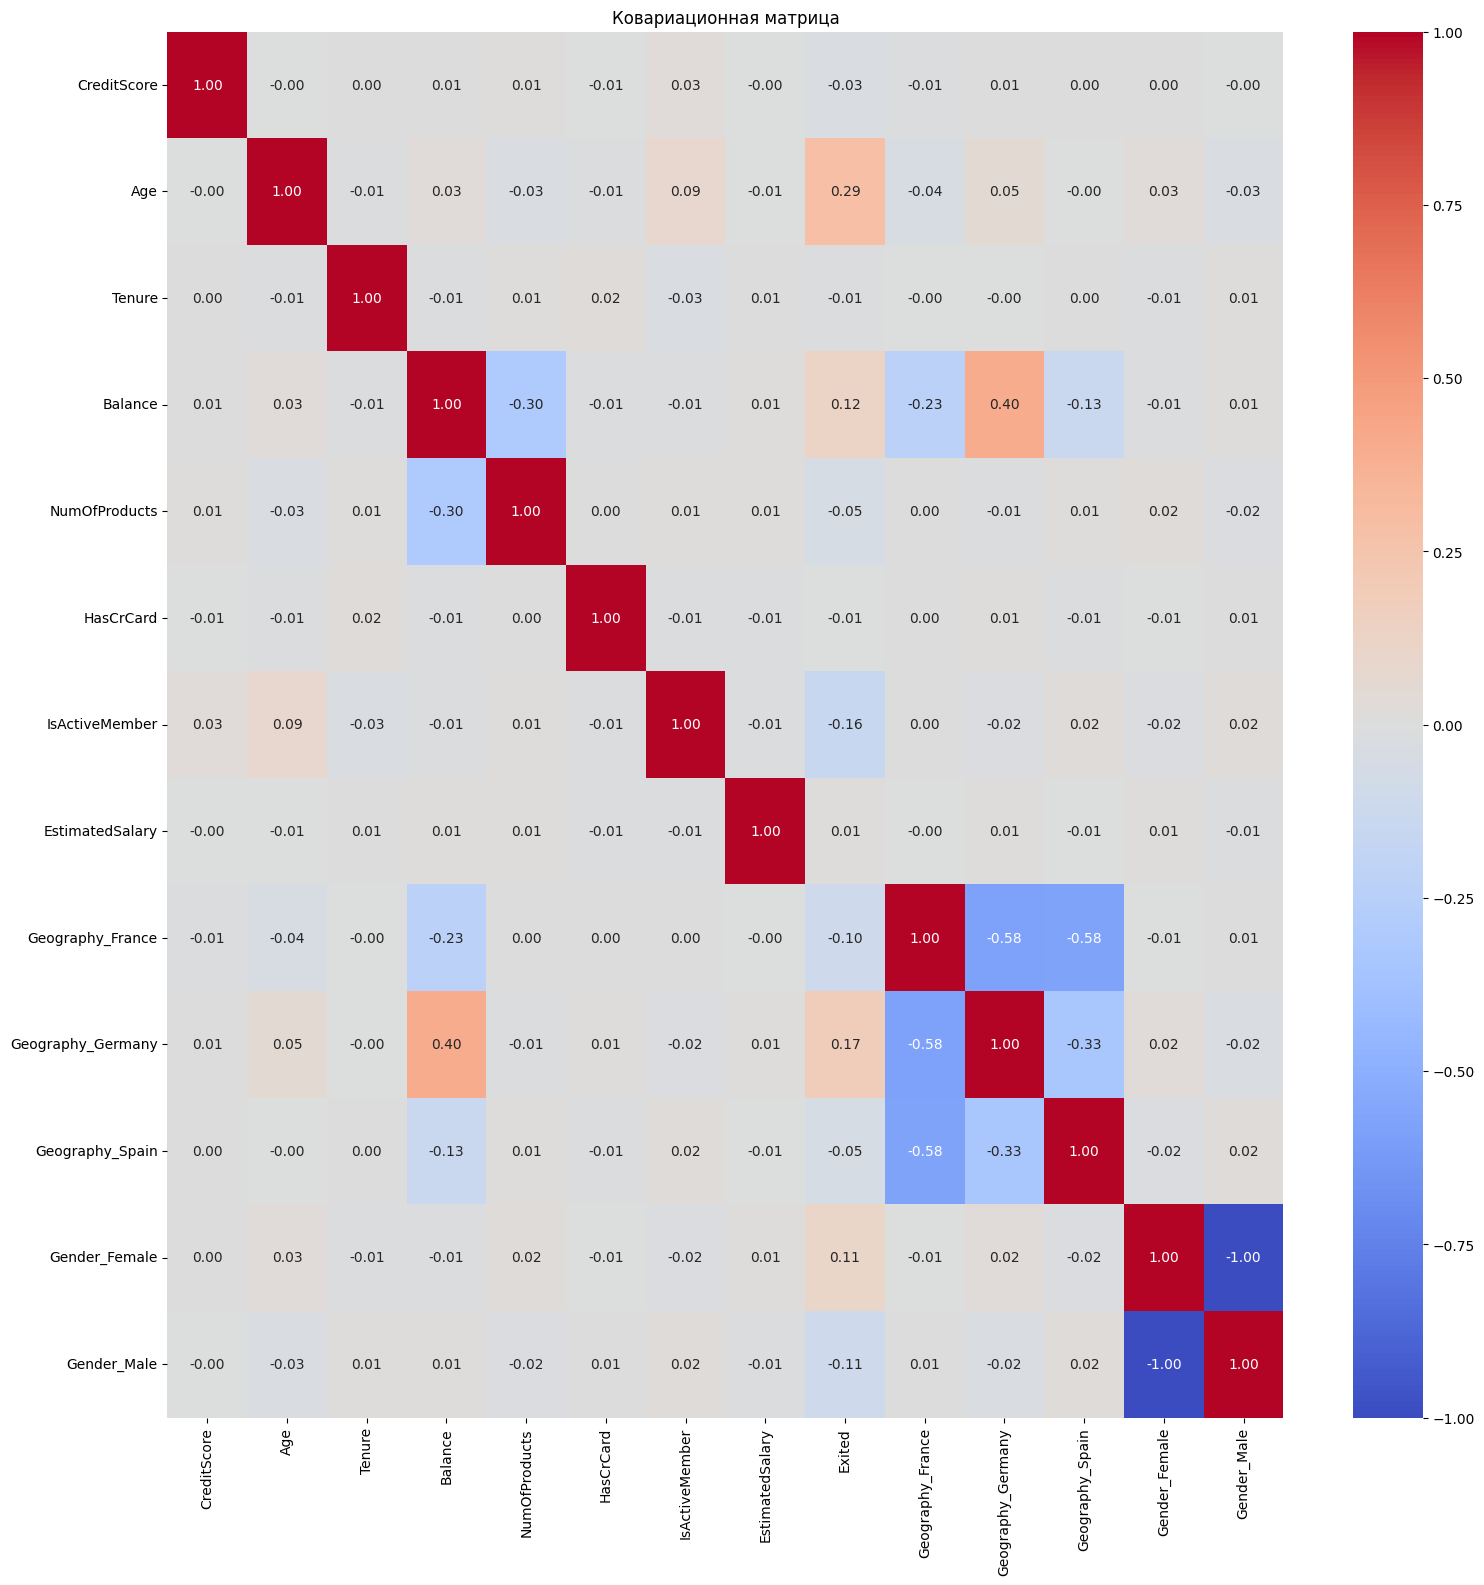

In [6]:
corr_matrix = baseline_ds.corr().drop("Exited", axis=0)

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Ковариационная матрица")
plt.show()

Как видим, у нас есть мультиколлинеарные признаки `Gender_Male` и `Geography_Germany`. Попробуем убрать их из датасета и проверить, улучшилось ли после данной оптимизации итоговое качество модели.

In [5]:
optimized_ds = baseline_ds.drop(columns=["Gender_Male", "Geography_Germany"])

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.ensemble.RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8685
Precision: 0.7664
Recall: 0.4758
F1-Score: 0.5871

Confusion Matrix:
[[1550   57]
 [ 206  187]]


Как видно, после проведенных оптимизаций значения метрик улучшились, но незначительно, что связанно с тем, что деревья решений и смешанный лес, который основан на них, хорошо справляются с избыточностью информации.

#### Подбор гиперпараметров

Иногда значения гиперпараметров, установленные в модели по умолчанию, не всегда являются оптимальными для конкретного датасета.

Поэтому, иногда имеет смысл подобрать более оптимальные значения гиперпараетров, которые больше подходить для текущего датасета.

Попробуем подобрать такие значения гиперпараметров на основе алгоритма grid search.

In [8]:
param_grid = {
  "n_estimators": [5, 10, 20],
  "max_depth": [None, 5, 10, 20],
  "min_samples_split": [2, 5, 10],
  "min_samples_leaf": [1, 2, 4],
  "max_features": ["sqrt", "log2", None],
}

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)
model = sklearn.ensemble.RandomForestClassifier(random_state=42)

grid_search = sklearn.model_selection.GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

# Вывод результатов

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print_model_metrics(best_model, X_test, y_test)


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
Accuracy: 0.8625
Precision: 0.7341
Recall: 0.4707
F1-Score: 0.5736

Confusion Matrix:
[[1540   67]
 [ 208  185]]


Как видно по значениям метрик, подбор гиперпараметров не дал положительного результата - модель стала показывать немного хуже показатели целевых метрик, что говорит нам о том, что значения гиперпараметров, установленные в модели по умолчанию, являются наиболее оптимальными.

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма дерева решения для задачи регрессии. Решение я реализовал в виде класса `MyRandomForestClassifier`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Так как смешанный лес является ансамблевым методом, то в его работе участвуют другие модели. В нашем случае это дерево решений. В качестве такой вспомогательной модели была взята имплементация алгоритма дерева решений из лабораторной работы №3.

Также, так как процесс обучения стал значительно дольше, то была добавлена строка для отслеживания прогресса обучения модели.

In [27]:
_PredictedClass = int


@dataclass
class _SplitInfo:
  index: int
  threshold: float


@dataclass
class _TreeNode:
  split_info: _SplitInfo
  left: Union["_TreeNode", _PredictedClass]
  right: Union["_TreeNode", _PredictedClass]


class MyDecisionTreeClassifier:
  def __init__(self, *, max_depth=float("inf")):
    self.__max_depth = max_depth
    self.__tree = None

  def __build_decision_tree(self, X, y, depth=0):
    n, m = X.shape
    unique_classes = set(y)

    if len(unique_classes) == 1 or n <= 1:
      return unique_classes.pop()

    if depth >= self.__max_depth:
      return collections.Counter(y).most_common(1)[0][0]

    best_split = self._best_split(X, y)
    if best_split is None:
      raise ValueError()

    left_part, right_part = self.__split_data(X, y, best_split)

    return _TreeNode(
      split_info=best_split,
      left=self.__build_decision_tree(*left_part, depth + 1),
      right=self.__build_decision_tree(*right_part, depth + 1),
    )

  def __split_data(self, X, y, split_info):
    x = X[:, split_info.index]
    left_ids = x <= split_info.threshold
    right_ids = x > split_info.threshold

    return (X[left_ids], y[left_ids]), (X[right_ids], y[right_ids])

  def _best_split(self, X, y):
    _, m = X.shape
    best_split = max(
      (
        _SplitInfo(index=feature_index, threshold=threshold)
        for feature_index in range(m)
        for threshold in self.__get_thresholds(X, feature_index)
      ),
      key=lambda split_info: self.__get_info_gain(X, y, split_info.index, split_info.threshold),
      default=None,
    )

    if self.__get_info_gain(X, y, best_split.index, best_split.threshold) == -float("inf"):
      return None
    return best_split

  def __get_info_gain(self, X, y, feature_index, threshold):
    feature_values = X[:, feature_index]
    left_indices = feature_values <= threshold
    right_indices = feature_values > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
      return -float('inf')

    left_y = y[left_indices]
    right_y = y[right_indices]

    l = self.__get_entropy(left_y)
    r = self.__get_entropy(right_y)

    n = len(y)
    return self.__get_entropy(y) - (len(left_y) / n * l + len(right_y) / n * r)

  def __get_thresholds(self, X, feature_id):
    return np.unique(X[:, feature_id])

  def __get_entropy(self, y):
    class_counts = np.bincount(y)
    probabilities = class_counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

  def __predict(self, x):
    cursor = self.__tree

    while isinstance(cursor, _TreeNode):
      feature_value = x[cursor.split_info.index]
      predictor = feature_value <= cursor.split_info.threshold
      cursor = [cursor.right, cursor.left][predictor]

    return cursor

  def fit(self, X, y):
    self.__tree = self.__build_decision_tree(X, y)

  def predict(self, X):
    return np.array(list(map(self.__predict, X)))

In [35]:
def _get_max_value(param, default):
  if param == "sqrt":
    return int(math.sqrt(default))
  if param is None:
    return default
  return param


def _with_retries(func):
  while True:
    try:
      return func()
    except:
      pass


class MyRandomForestClassifier:
  def __init__(self, trees_amount=10, max_depth=5, max_features=2):
    self.__trees_amount = trees_amount
    self.__tree_max_depth = max_depth
    self.__max_features = max_features
    self.__trees = None

  def __create_new_tree(self, X, y):
    n, m = X.shape
    max_features = _get_max_value(self.__max_features, m)
    max_depth = _get_max_value(self.__tree_max_depth, n)

    sample_ids = np.random.choice(n, size=n, replace=True)
    feature_ids = np.random.choice(m, max_features, replace=False)

    selected_x = X[sample_ids][:, feature_ids]
    selected_y = y[sample_ids]

    tree = MyDecisionTreeClassifier(max_depth=max_depth)
    tree.fit(selected_x, selected_y)
    return tree, feature_ids

  def fit(self, X, y):
    self.__trees = [
      _with_retries(lambda: self.__create_new_tree(X, y))
      for _ in tqdm.tqdm(range(self.__trees_amount))
    ]

  def predict(self, X):
    tree_predictions = np.array([tree.predict(X[:, features]) for tree, features in self.__trees])
    return [collections.Counter(pred).most_common(1)[0][0] for pred in tree_predictions.T]

#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [38]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyRandomForestClassifier(max_depth=float("inf"))
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

100%|██████████| 10/10 [03:45<00:00, 22.50s/it]
Accuracy: 0.7475
Precision: 0.2407
Recall: 0.1323
F1-Score: 0.1708

Confusion Matrix:
[[1443  164]
 [ 341   52]]


Как видим, по сравнению с моделью из пункта 2, имплементированная модель показывает значительно хуже результаты. Связано это с отсутствием тонкой настройки гиперпараметров и использованием базового алгоритма работы смешанного дерева, который лишен оптимизаций.

Отдельное внимание стоит уделить метрике "F1-Score", которая оказалась в разы хуже, чем в модели из пункта 2. Это говорит нам о том, что модель не справляется с несбалансированностью классов в датасете.

In [42]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = MyRandomForestClassifier(
    trees_amount=20,
    max_depth="sqrt",
)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

100%|██████████| 20/20 [05:33<00:00, 16.69s/it]
Accuracy: 0.7640
Precision: 0.2238
Recall: 0.0814
F1-Score: 0.1194

Confusion Matrix:
[[1496  111]
 [ 361   32]]


Как видно, даже при улучшенном бейзлайне имплементированная модель показывает хуже результаты, чем модель из пункта 3, что также связано с тем, что она не учитывает несбалансированность классов.

По сравнению с моделью, обученной на бейзлайне до оптимизаций, улучшения модели незначительные, что говорит нам о том, что учет несбалансированности классов играл основную роль в росте качества модели.

## Регрессия

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [43]:
!kaggle datasets download -q -p dataset -d denkuznetz/taxi-price-prediction
!unzip dataset/taxi-price-prediction.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction
License(s): apache-2.0
Archive:  dataset/taxi-price-prediction.zip
  inflating: dataset/taxi_trip_pricing.csv  


In [45]:
ds = pd.read_csv("/content/dataset/taxi_trip_pricing.csv")
baseline_ds = ds.dropna(subset=["Trip_Price"])

numeric_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
]
baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))

categorical_features = [
  "Time_of_Day",
  "Day_of_Week",
  "Traffic_Conditions",
  "Weather",
]

for feature in categorical_features:
  encoded_feature = pd.get_dummies(baseline_ds[feature], prefix=feature, dtype=int)
  baseline_ds[encoded_feature.columns] = encoded_feature
  baseline_ds = baseline_ds.drop(columns=[feature])

baseline_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekday,Day_of_Week_Weekend,Traffic_Conditions_High,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Clear,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,0,0,1,0,1,0,0,1,0,1,0,0
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,0,1,0,0,0,1,1,0,0,1,0,0
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,0,1,0,0,1,0,0,1,0,0,0,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,0,1,0,0,1,0,1,0,0,1,0,0
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,1,0,0,0,0,1,0,0,1,1,0,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [46]:
def generate_train_data(dataset, *, target_feature="Trip_Price", test_size=0.2, random_state=42):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]
  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
  r2 = sklearn.metrics.r2_score(y_test, y_pred)

  return { "mae": mae, "r2": r2 }


def print_model_metrics(model, X_test, y_test):
  results = get_model_metrics(model, X_test, y_test)

  print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
  print(f"R-squared (R2): {results['r2']:.4f}")

Обучим теперь модель случайного леса для решения задачи регрессии на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [47]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 6.2614
R-squared (R2): 0.9458


Как видим, даже на неоптимизированном бейзлайне модель показывает отличные результаты, о чем свидетельствуют высокие значения метрики "R2".

Попробуем применить к случайному лесу гипотезы, которые мы раньше применяли к дереву решений.

### 3. Улучшение бейзлайна

#### Feature engineering

При решении прошлых лабораторных работ самым эффективным методом оптимизации бейзлайна всегда было добавление новых признаков с использованием нелинейных функций.

Попробуем применить ту же гипотезу и к случайному лесу. Для этого расширим датасет новыми признаками `Trip_Distance_km`, `Per_Km_Rate` и `Trip_Duration_Minutes`, `Per_Minute_Rate`, которые мы определили в прошлых лабораторных работах.

In [48]:
optimized_ds = baseline_ds.copy()

optimized_ds["Per_Km_Rate__Trip_Distance_km"] = optimized_ds["Trip_Distance_km"] * optimized_ds["Per_Km_Rate"]
optimized_ds = optimized_ds.drop(columns=["Trip_Distance_km", "Per_Km_Rate"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.4902
R-squared (R2): 0.9291


In [49]:
optimized_ds_2 = optimized_ds.copy()

optimized_ds_2["Per_Minute_Rate__Trip_Duration_Minutes"] = optimized_ds_2["Trip_Duration_Minutes"] * optimized_ds_2["Per_Minute_Rate"]
optimized_ds_2 = optimized_ds_2.drop(columns=["Trip_Duration_Minutes", "Per_Minute_Rate"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_2)

model = sklearn.ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 4.9117
R-squared (R2): 0.9353


Как видим, после внедрения новых признаков, показатель метрики "MAE" значительно уменьшился. Однако, с другой стороны, хоть и незначительно, но уменьшился показатель метрики "R2". Итого, можно сказать, что гипотеза оказалась верной и дала положительный результат при оптимизации бейзлайна.

#### Избавление от выбросов

Вторым по эффективности методом по оптимизации бейзлайна была фильтрация значений признаков в датасете. Попробуем применить ту же гипотезу и для случайного леса.

Однако, в этот раз в качестве целового признака возьмем ранее добавленный `Per_Km_Rate__Trip_Distance_km`. Для начала проанлизируем значения признака на наличие выбросов. Для этого выведем графики, которые бы нам дали больше информации о распределении значений и зависимости целевой переменной от них.

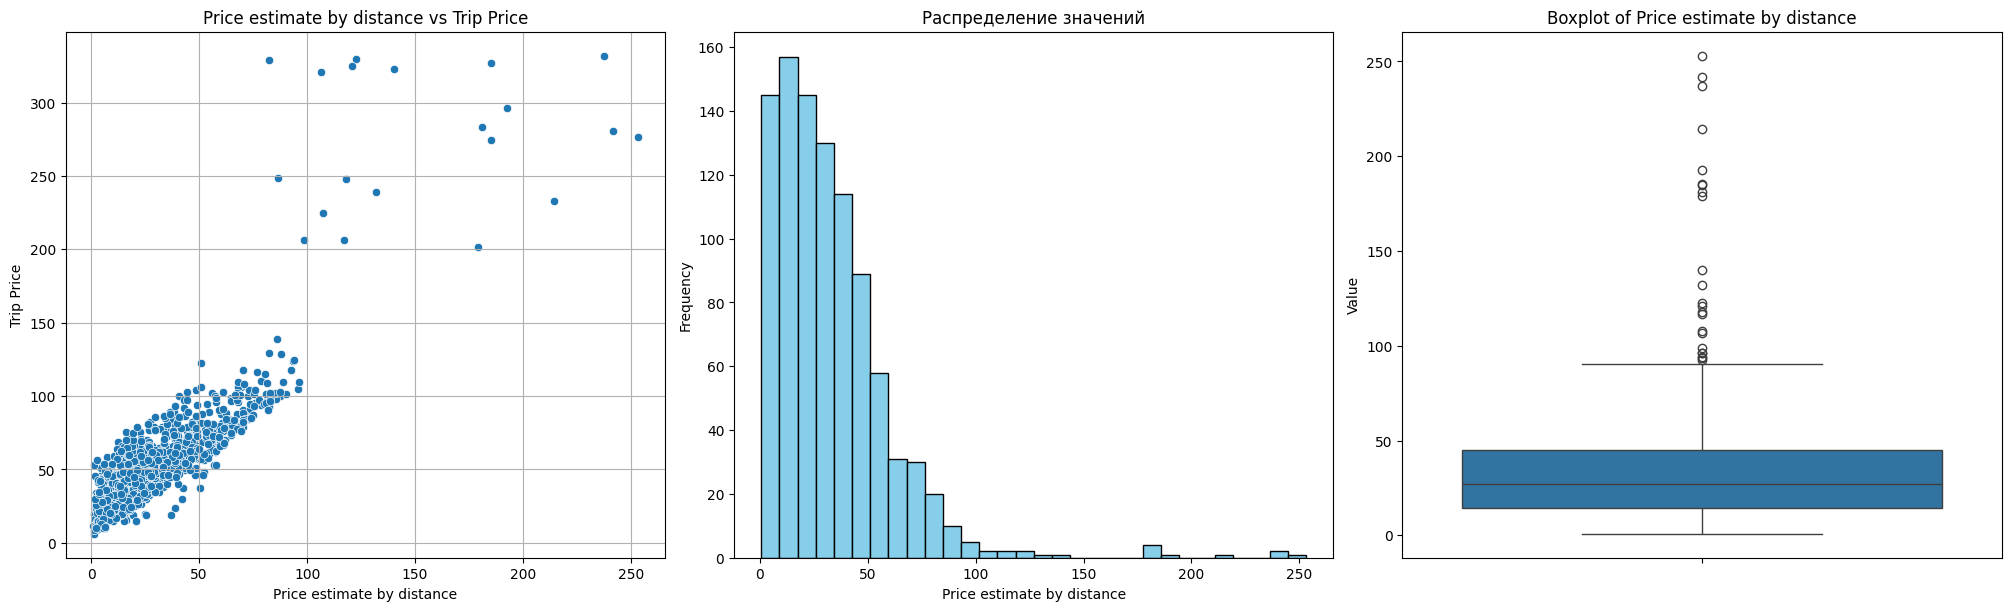

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

sns.scatterplot(
    x="Per_Km_Rate__Trip_Distance_km",
    y="Trip_Price",
    data=optimized_ds_2,
    ax=axes[0]
)
axes[0].set_title("Price estimate by distance vs Trip Price")
axes[0].set_xlabel("Price estimate by distance")
axes[0].set_ylabel("Trip Price")
axes[0].grid(True)

axes[1].hist(optimized_ds_2["Per_Km_Rate__Trip_Distance_km"], bins=30, color="skyblue", edgecolor="black")
axes[1].set_title("Распределение значений")
axes[1].set_xlabel("Price estimate by distance")
axes[1].set_ylabel("Frequency")

sns.boxplot(
    y="Per_Km_Rate__Trip_Distance_km",
    data=optimized_ds_2,
    ax=axes[2]
)
axes[2].set_title("Boxplot of Price estimate by distance")
axes[2].set_ylabel("Value")

plt.show()

Как видно по графикам:

1. Целевая переменная действительно сильно зависит от значений рассматриваемого признака

2. Распределение значений для целевого признака слишком смещенное и имеет длинный "хвост"

Попробуем избавиться от выбросов, используя метод интерквартильного размаха.

In [52]:
Q1 = optimized_ds_2["Per_Km_Rate__Trip_Distance_km"].quantile(0.25)
Q3 = optimized_ds_2["Per_Km_Rate__Trip_Distance_km"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

optimized_ds_3 = optimized_ds_2[(lower_bound <= optimized_ds["Per_Km_Rate__Trip_Distance_km"]) & (optimized_ds["Per_Km_Rate__Trip_Distance_km"] <= upper_bound)]

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = sklearn.ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 3.2798
R-squared (R2): 0.9451


Как видно, удаление выбросов из данных дало крайне положительный результат на итоговое значение метрики "MAE", и немного улучшего показатели метрики "R2". А следовательно, гипотеза оказалась верной!

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма смешанного леса для задачи регрессии. Решение я реализовал в виде класса `MyRandomForestRegressor`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Так как смешанный лес является ансамблевым методом, то в его работе участвуют другие модели. В нашем случае это дерево решений. В качестве такой вспомогательной модели была взята имплементация алгоритма дерева решений из лабораторной работы №3 для решения задачи регрессии.

Также, так как процесс обучения стал значительно дольше, то была добавлена строка для отслеживания прогресса обучения модели.

In [85]:
_PredictedClass = int


@dataclass
class _SplitInfo:
  index: int
  threshold: float


@dataclass
class _TreeNode:
  split_info: _SplitInfo
  left: Union["_TreeNode", _PredictedClass]
  right: Union["_TreeNode", _PredictedClass]



# TODO: make a base class for regressor & classifier
class MyDecisionTreeRegressor:
  def __init__(self, *, max_depth=float("inf")):
    self.__max_depth = max_depth
    self.__tree = None

  def __build_decision_tree(self, X, y, depth=0):
    n, _ = X.shape
    unique_classes = set(y)

    if len(unique_classes) == 1 or n <= 1:
      return unique_classes.pop()

    if depth >= self.__max_depth:
      return collections.Counter(y).most_common(1)[0][0]

    best_split = self.__get_best_split(X, y)
    left_part, right_part = self.__split_data(X, y, best_split)

    return _TreeNode(
      split_info=best_split,
      left=self.__build_decision_tree(*left_part, depth + 1),
      right=self.__build_decision_tree(*right_part, depth + 1),
    )

  def __split_data(self, X, y, split_info):
    x = X[:, split_info.index]
    left_ids = x <= split_info.threshold
    right_ids = x > split_info.threshold

    return (X[left_ids], y[left_ids]), (X[right_ids], y[right_ids])

  def __get_best_split(self, X, y):
    _, m = X.shape
    return max(
      (
        _SplitInfo(index=feature_index, threshold=threshold)
        for feature_index in range(m)
        for threshold in self.__get_thresholds(X, feature_index)
      ),
      key=lambda split_info: self.__get_variance_reduction(X, y, split_info.index, split_info.threshold),
      default=-float('inf'),
    )

  def __get_variance_reduction(self, X, y, feature_index, threshold):
    feature_values = X[:, feature_index]
    left_indices = feature_values <= threshold
    right_indices = feature_values > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
      return -float('inf')

    left_y = y[left_indices]
    right_y = y[right_indices]

    n = len(y)
    left_var = np.var(left_y) * len(left_y) / n
    right_var = np.var(right_y) * len(right_y) / n

    return np.var(y) - (left_var + right_var)

  def __get_thresholds(self, X, feature_id):
    return np.unique(X[:, feature_id])

  def __predict(self, x):
    cursor = self.__tree

    while isinstance(cursor, _TreeNode):
      feature_value = x[cursor.split_info.index]
      cursor = cursor.left if feature_value <= cursor.split_info.threshold else cursor.right

    return cursor

  def fit(self, X, y):
    self.__tree = self.__build_decision_tree(X, y)

  def predict(self, X):
    return np.array(list(map(self.__predict, X)))

In [86]:
class MyRandomForestRegressor:
    def __init__(self, trees_amount=100, max_depth=None):
        self.__trees_amount = trees_amount
        self.__tree_max_depth = max_depth
        self.__trees = None

    def __create_new_tree(self, X, y):
        n, _ = X.shape
        max_depth = _get_max_value(self.__tree_max_depth, n)
        sample_ids = np.random.choice(n, size=n, replace=True)

        selected_x = X[sample_ids]
        selected_y = y[sample_ids]

        tree = MyDecisionTreeRegressor(max_depth=max_depth)
        tree.fit(selected_x, selected_y)
        return tree

    def fit(self, X, y):
        self.__trees = [
            _with_retries(lambda: self.__create_new_tree(X, y))
            for _ in tqdm.tqdm(range(self.__trees_amount))
        ]
        print()

    def predict(self, X):
        y_pred = np.array([ tree.predict(X) for tree in self.__trees ])
        return np.mean(y_pred, axis=0)

#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [87]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyRandomForestRegressor(trees_amount=10, max_depth=float("inf"))
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Mean Absolute Error (MAE): 6.3680
R-squared (R2): 0.9625


Как видим, итоговые значения полученных метрик оказались очень близкими к тем, которые были у модели из пункта 2, что говорит нам о схожести алгоритмов имплементации с реализацией из `sklearn`.

Однако, значения хоть незначительно, но отличаются, что может быть обосновано наличие случайности в некоторых этапах алгоритма.

In [89]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = MyRandomForestRegressor(trees_amount=10, max_depth=float("inf"))
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Mean Absolute Error (MAE): 4.2440
R-squared (R2): 0.9190


Как видно, улучшения, которые были проделаны по отношению к бейзлайну, оказали положительное влияние на итоговое качество имплементированной модели.

В сравнении с моделью из пункта 3, имплементированная модель имеет хуже показатели метрик, что также связано с элементами случайности при работе алгоритма и, возможно, выбором базового алгоритма работы случайного дерева, которые лишен оптимизаций.